<a href="https://colab.research.google.com/github/stefanciprian/rd/blob/main/prices_and_volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

Load data from CSV, but first you need to uload the CSV file in the File System in Google Collab.

In [ ]:
import pandas as pd

df = pd.read_csv('LUMN.csv')
df.head(10)
df.sort_index(ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume
252,2024-08-01,3.27,4.20,3.26,4.1306,4.1306,52773643
251,2024-07-31,2.59,3.15,2.36,3.1500,3.1500,75766000
250,2024-07-30,2.02,3.44,1.94,2.6700,2.6700,161091500
249,2024-07-29,1.80,1.99,1.75,1.9400,1.9400,31081100
248,2024-07-26,1.69,1.77,1.68,1.7700,1.7700,18386700
...,...,...,...,...,...,...,...
4,2023-08-07,1.71,1.75,1.64,1.7400,1.7400,30195600
3,2023-08-04,1.67,1.77,1.64,1.6600,1.6600,34052900
2,2023-08-03,1.76,1.78,1.68,1.6800,1.6800,19715300
1,2023-08-02,1.75,1.87,1.68,1.7900,1.7900,39992700


Get data from Yahoo

In [1]:
!pip install yfinance==0.2.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.44
    Uninstalling yfinance-0.2.44:
      Successfully uninstalled yfinance-0.2.44


In [6]:
import yfinance as yf

ticker = "AAPL" # Example ticker for Microsoft
start_date = "2024-05-01"
end_date = "2024-10-20"  # Or today's date

try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"No data found for {ticker} within the specified date range.")
    else:
        display(data)  # Display using Colab's display function
except Exception as e:
    print(f"An error occurred: {e}")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted
No data found for AAPL within the specified date range.


Scrape Yahoo site

In [9]:
pip install requests beautifulsoup4

In [12]:
import requests
from bs4 import BeautifulSoup
import time
import json

def get_stock_volumes_yahoo(ticker: str) -> dict:
    # Construct the URL
    url = f"https://finance.yahoo.com/quote/{ticker}/history/"
    print(url)

    # Add a delay to mimic human browsing behavior
    time.sleep(2)  # Adds a 2-second delay

    # Create a request with a user-agent header
    headers = {
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                       "(KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36")
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Select the table elements containing stock volumes
    stock_volumes = []
    table = soup.find('table')  # Modify this selector as per your requirement

    if table:
        for row in table.find_all('tr'):
            columns = row.find_all('td')
            print(columns)
            if len(columns) > 1:  # Ensuring we have more than one column
                volume = columns[6].get_text()  # Assuming the 7th column contains the volume
                stock_volumes.append(volume)

    # Return the stock volumes as a JSON response
    return json.dumps({"volumes": stock_volumes}, indent=4)

# Example usage
ticker = "AAPL"
try:
    result = get_stock_volumes_yahoo(ticker)
    print(result)
except Exception as e:
    print(f"Error: {e}")


https://finance.yahoo.com/quote/AAPL/history/
[]
[<td class="yf-ewueuo">Oct 21, 2024</td>, <td class="yf-ewueuo">234.45</td>, <td class="yf-ewueuo">236.85</td>, <td class="yf-ewueuo">234.45</td>, <td class="yf-ewueuo">236.60</td>, <td class="yf-ewueuo">236.60</td>, <td class="yf-ewueuo">20,917,694</td>]
[<td class="yf-ewueuo">Oct 18, 2024</td>, <td class="yf-ewueuo">236.18</td>, <td class="yf-ewueuo">236.18</td>, <td class="yf-ewueuo">234.01</td>, <td class="yf-ewueuo">235.00</td>, <td class="yf-ewueuo">235.00</td>, <td class="yf-ewueuo">46,416,300</td>]
[<td class="yf-ewueuo">Oct 17, 2024</td>, <td class="yf-ewueuo">233.43</td>, <td class="yf-ewueuo">233.85</td>, <td class="yf-ewueuo">230.52</td>, <td class="yf-ewueuo">232.15</td>, <td class="yf-ewueuo">232.15</td>, <td class="yf-ewueuo">32,993,800</td>]
[<td class="yf-ewueuo">Oct 16, 2024</td>, <td class="yf-ewueuo">231.60</td>, <td class="yf-ewueuo">232.12</td>, <td class="yf-ewueuo">229.84</td>, <td class="yf-ewueuo">231.78</td>, <

# ARIMA

We calculate the ARIMA for the Volumes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.4
    Uninstalling statsmodels-0.14.4:
      Successfully uninstalled statsmodels-0.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.13.6 requires statsmodels>=0.14.0, but you have statsmodels 0.13.5 which is incompatible.


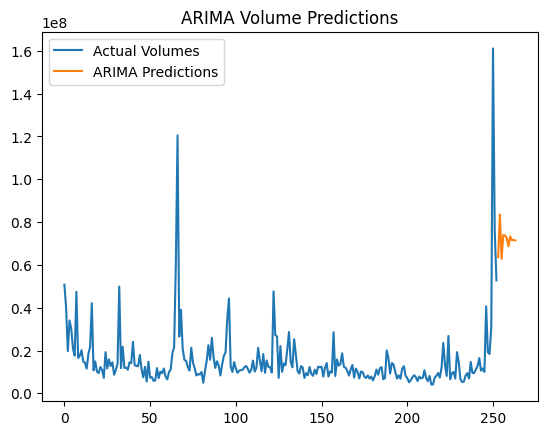

In [ ]:
!pip install statsmodels==0.13.5

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

volumes = df['Volume']

model = ARIMA(volumes, order=(5, 1, 0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(volumes), end=len(volumes) + 10)
# Predicts for the next 10 periods

plt.plot(volumes, label='Actual Volumes')
plt.plot(predictions, label='ARIMA Predictions')
plt.legend()
plt.title('ARIMA Volume Predictions')
plt.show()

# Bayesian



In [ ]:
import numpy as np


# Define a class to hold our prior belief
class Prior:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

# Define a class to hold our likelihood
class Likelihood:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

# Function to update our prior with new evidence
def bayesian_update(prior, likelihood):
    prior_variance_inv = 1.0 / prior.variance
    likelihood_variance_inv = 1.0 / likelihood.variance

    updated_variance = 1.0 / (prior_variance_inv + likelihood_variance_inv)
    updated_mean = updated_variance * (prior.mean * prior_variance_inv + likelihood.mean * likelihood_variance_inv)

    return Prior(mean=updated_mean, variance=updated_variance)

# Function to calculate mean and variance from records
def calculate_statistics(df, scale_factor=1):
    volumes = df['Volume'].astype(float) / scale_factor  # Scale the volumes
    mean = np.mean(volumes)
    variance = np.var(volumes)
    return mean, variance

# Function to apply Bayesian update using the DataFrame
def bayesian_with_volumes_df(df, scale_factor=1):
    try:
        # Sort DataFrame by index in descending order to get the most recent records at the top
        df = df.sort_index(ascending=False)

        # Calculate statistics for the prior using all records
        prior_mean, prior_variance = calculate_statistics(df, scale_factor)

        # Extract the most recent record as new evidence
        latest_record = df.iloc[0]  # Get the most recent row
        new_evidence_volume = float(latest_record['Volume']) / scale_factor

        # For simplicity, use the prior variance as the variance for the new evidence
        new_evidence_variance = prior_variance

        # Define the prior and likelihood based on these values
        prior = Prior(mean=prior_mean, variance=prior_variance)
        likelihood = Likelihood(mean=new_evidence_volume, variance=new_evidence_variance)

        # Perform Bayesian update
        updated_prior = bayesian_update(prior, likelihood)

        print(f"Updated Prior: mean = {updated_prior.mean:.2f}, variance = {updated_prior.variance:.2f}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage with scaling (e.g., volumes in millions)
bayesian_with_volumes_df(df, scale_factor=1_000_000)


Updated Prior: mean = 34.03, variance = 112.02


# Fractional Gaussian Noise (fGn)

Simulated fGn: [ 1.66916245  0.70073021 -1.16240135 -0.9020473  -0.48581489  0.40820395
 -0.96294032  0.21764473  0.50716964 -1.05880565 -1.84955875  0.43388645
 -0.373131    0.45326383  0.97432369  1.1369479   1.75281301 -0.19305754
  1.98970168 -1.77615082 -0.36166259  0.16158066 -1.41237809 -1.50787076
  0.61174911 -0.54403212 -0.49133931 -0.56284258  0.91514619  0.54184098
 -0.64924699 -0.32625574 -0.5355102   2.1670219   0.11114381 -0.07279605
  2.60185702  1.19280819  0.47498661  1.93791042  0.78262482  2.2521221
  1.68253841  1.21881702  0.94661498 -0.16034371 -0.21861312 -0.19684841
 -0.45774394 -0.39554159 -0.43738645 -0.96617353  1.60830942 -1.29773261
 -0.51496895 -0.28150593 -0.55089732  0.03585545 -0.17221417  0.15717886
 -0.67950697  0.68974523 -0.08281495  1.44230391  1.19033626  1.55369815
  0.68812887  1.05991214 -0.76690644 -0.40426889 -0.7875747  -0.4288892
 -0.24506318  0.87123576 -0.02069232  0.82388473 -1.42321168  0.82144976
 -0.17653245  0.00436568 -0.85379391  

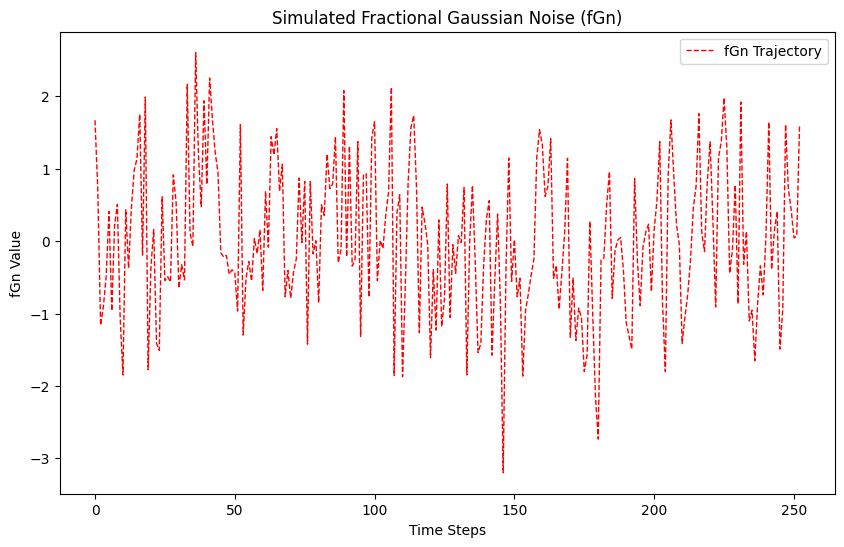

In [ ]:
import numpy as np
from scipy.linalg import cholesky

def generate_covariance_matrix(hurst, size):
    cov_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            cov_matrix[i, j] = 0.5 * ((i + 1) ** (2 * hurst) + (j + 1) ** (2 * hurst) - abs(i - j) ** (2 * hurst))

    return cov_matrix

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

def simulate_fbm(hurst, length):
    cov_matrix = generate_covariance_matrix(hurst, length)
    cholesky_decomp = cholesky(cov_matrix, lower=True)
    z = np.random.normal(size=(length,))

    fbm_series = cholesky_decomp.dot(z)
    return fbm_series

def simulate_fgn(hurst, length):
    fbm_series = simulate_fbm(hurst, length + 1)
    fgn_series = np.diff(fbm_series)
    return fgn_series

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))

# Simulate fGn
fgn_series = simulate_fgn(hurst, len(df['Volume']))
print(f"Simulated fGn: {fgn_series}")

plt.figure(figsize=(10, 6))

# Plot fGn
plt.plot(fgn_series, label='fGn Trajectory', color='r', linestyle='--', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('fGn Value')
plt.title('Simulated Fractional Gaussian Noise (fGn)')
plt.legend()
plt.show()


# Fractional Lévy Stable Motion (FLSM)

Simulated FLSM: [ 8.73357249e-01  2.18603645e+00 -7.31114828e+00 -4.89174684e+00
 -6.52377402e+00 -7.51360925e+00 -5.69229197e+00 -4.38218845e+00
 -2.83467904e+00 -1.88074717e+00 -4.46343423e-01 -1.20347848e+00
 -1.30324338e+00  3.75193966e-02  7.63755783e-01 -7.54525173e-01
  8.40802483e+00  9.64514979e+00  1.26688298e+01  1.47107645e+01
  1.63883819e+01  1.70719686e+01  1.72104147e+01  1.78341498e+01
  1.89638636e+01  2.86523971e+01  4.17575092e+01  4.60655868e+01
  4.83741805e+01  5.24220806e+01  5.41262454e+01  5.67778873e+01
  5.70389633e+01  5.95557923e+01  6.19997188e+01  5.03584515e+01
  4.69248250e+01  4.82564120e+01  4.38065232e+01  4.14625731e+01
  4.04283278e+01  4.09019775e+01  3.93506765e+01  3.79870638e+01
  3.70046303e+01  3.60760539e+01  3.58098077e+01 -9.50237979e+00
 -1.89248021e+01 -2.45445439e+01 -2.69481065e+01 -2.82835092e+01
 -2.99612024e+01 -3.42268178e+01 -3.50696667e+01 -4.65781475e+01
 -4.89181695e+01 -4.73887973e+01 -5.56269492e+01 -5.74773780e+01
 -5.89856

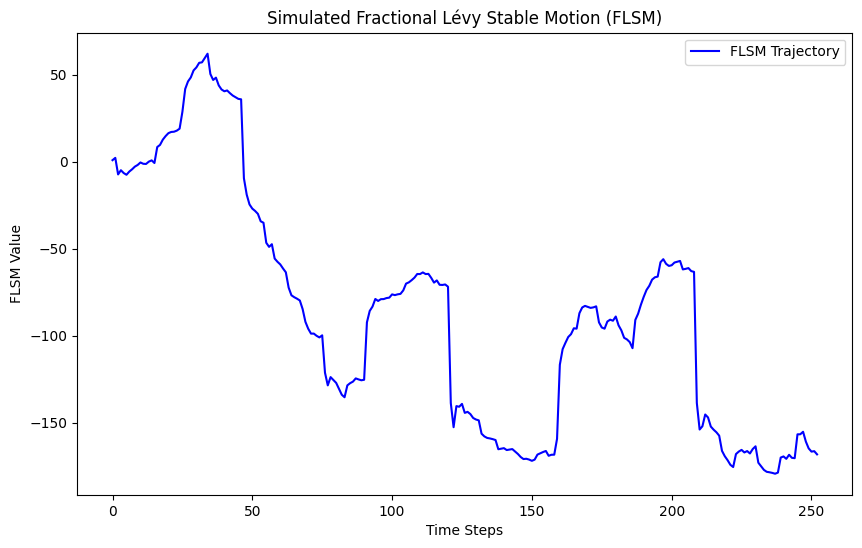

In [ ]:
import numpy as np
from scipy.linalg import cholesky

def generate_covariance_matrix(hurst, size):
    cov_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            cov_matrix[i, j] = 0.5 * ((i + 1) ** (2 * hurst) + (j + 1) ** (2 * hurst) - abs(i - j) ** (2 * hurst))

    return cov_matrix

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

def levy_stable(alpha, beta, sigma, mu):
    u = np.random.uniform(-np.pi/2, np.pi/2)
    w = np.random.normal()

    if alpha == 1.0:
        return mu + beta * np.tan(np.pi / 2 + beta * u) * sigma * np.log(np.pi / 2 + beta * u)

    zeta = beta * np.tan(np.pi / 2 * alpha)
    term1 = (1 + zeta ** 2) ** 0.5
    term2 = np.tan(alpha * u)
    term3 = np.log(1 + zeta * term2)
    term4 = (1 / alpha) * (term1 * term2 - zeta * (w - term3))

    return mu + sigma * term4

def simulate_flm(hurst, length, alpha):
    cov_matrix = generate_covariance_matrix(hurst, length)
    cholesky_decomp = cholesky(cov_matrix, lower=True)

    z = [levy_stable(alpha, 0.0, 1.0, 0.0) for _ in range(length)]
    z_matrix = np.array(z)

    flm_series = cholesky_decomp.dot(z_matrix)
    return flm_series

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))

# Simulate FLSM
flm_series = simulate_flm(hurst, len(df['Volume']), alpha=1.5)
print(f"Simulated FLSM: {flm_series}")

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(flm_series, label='FLSM Trajectory', color='b')

# Add labels and title
plt.xlabel('Time Steps')
plt.ylabel('FLSM Value')
plt.title('Simulated Fractional Lévy Stable Motion (FLSM)')
plt.legend()

# Display the plot
plt.show()

# Higuchi Fractal Dimension

In [ ]:
import numpy as np

def higuchi_fractal_dimension(time_series, kmax):
    n = len(time_series)
    lengths = np.zeros(kmax)

    for k in range(1, kmax + 1):
        lk = 0.0
        for m in range(k):
            lmk = 0.0
            for i in range(m, n - k, k):
                lmk += abs(time_series[i + k] - time_series[i])
            lmk /= (n - m) / k
            lk += lmk
        lengths[k - 1] = lk / k

    log_lk = np.log10(lengths)
    log_k = np.log10(np.arange(1, kmax + 1))

    # Linear regression to calculate the slope
    slope = np.polyfit(log_k, log_lk, 1)[0]

    return slope

# Normalize the volumes
max_volume = max(df['Volume'])
normalized_volumes = [v / max_volume for v in df['Volume']]

# Calculate Higuchi Fractal Dimension
fractal_dimension = higuchi_fractal_dimension(normalized_volumes, 10)
print(f"Higuchi Fractal Dimension: {fractal_dimension}")
print('\nInterpretation of the Higuchi Fractal Dimension:')
print('1.0 ≤ HFD < 2.0: Indicates smoother or rougher data.')
print('HFD ≈ 1.5: Often observed in fractional Brownian motion.')
print('HFD > 2.0 or < 1.0: Unusual values.\n')

Higuchi Fractal Dimension: 0.07930563984346778

Interpretation of the Higuchi Fractal Dimension:
1.0 ≤ HFD < 2.0: Indicates smoother or rougher data.
HFD ≈ 1.5: Often observed in fractional Brownian motion.
HFD > 2.0 or < 1.0: Unusual values.



# Hurst Exponent

In [ ]:
import numpy as np

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))
print(f"Hurst Exponent: {hurst}")
# Print interpretation legend
print("\nInterpretation of the Hurst Exponent:")
print("H < 0.5: Suggests mean-reverting behavior.")
print("H = 0.5: Suggests a random walk.")
print("H > 0.5: Suggests trending behavior.\n")

Hurst Exponent: 0.6529419116306946

Interpretation of the Hurst Exponent:
H < 0.5: Suggests mean-reverting behavior.
H = 0.5: Suggests a random walk.
H > 0.5: Suggests trending behavior.



# Linear Regression

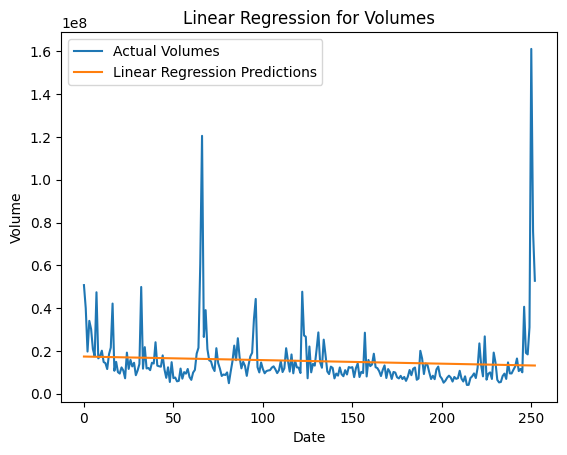

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the volume column is 'Volume'
X = np.arange(len(df)).reshape(-1, 1)  # Create a feature matrix with time steps
y = df['Volume']  # Target variable (volume)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Plot the results
plt.plot(df.index, y, label='Actual Volumes')  # Assuming 'df' has a datetime index
plt.plot(df.index, predictions, label='Linear Regression Predictions')
plt.legend()
plt.title('Linear Regression for Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Lorenz System

Lorenz trajectory: [[15.14410082  1.41098386  1.06248697]
 [15.00676965  1.81751728  1.08102175]
 [14.87487713  2.21966667  1.10541409]
 [14.74832502  2.61750067  1.13548359]
 [14.62701678  3.01108979  1.17105938]]


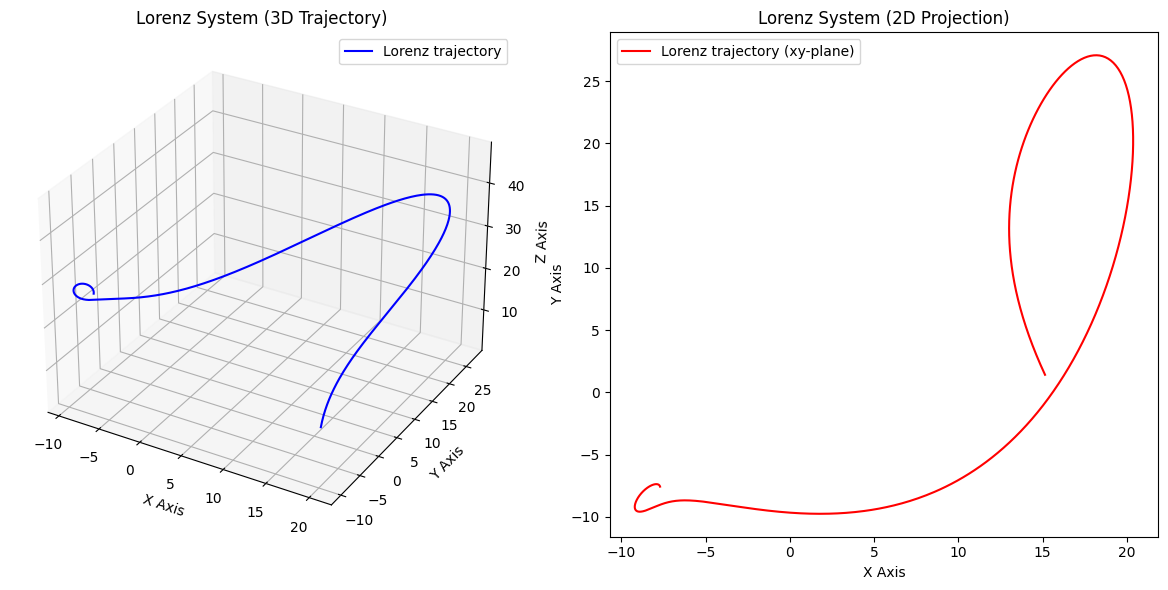

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def lorenz_system(initial_state, dt, steps):
    sigma = 10.0
    rho = 28.0
    beta = 8.0 / 3.0

    state = np.array(initial_state)
    trajectory = np.zeros((steps, 3))

    for i in range(steps):
        dx = sigma * (state[1] - state[0])
        dy = state[0] * (rho - state[2]) - state[1]
        dz = state[0] * state[1] - beta * state[2]

        state[0] += dx * dt
        state[1] += dy * dt
        state[2] += dz * dt

        trajectory[i] = state

    return trajectory

# Simulate Lorenz system
initial_state = [np.mean(df['Volume']) / 1_000_000, 1.0, 1.05]
lorenz_trajectory = lorenz_system(initial_state, dt=0.001, steps=1000)
print(f"Lorenz trajectory: {lorenz_trajectory[:5]}")  # Show first 5 points

# Extract x, y, z coordinates
x = lorenz_trajectory[:, 0]
y = lorenz_trajectory[:, 1]
z = lorenz_trajectory[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))

# 3D plot of Lorenz trajectory
ax_3d = fig.add_subplot(121, projection='3d')
ax_3d.plot(x, y, z, label='Lorenz trajectory', color='b')
ax_3d.set_xlabel('X Axis')
ax_3d.set_ylabel('Y Axis')
ax_3d.set_zlabel('Z Axis')
ax_3d.set_title('Lorenz System (3D Trajectory)')
ax_3d.legend()

# 2D plot of the same Lorenz trajectory projected onto the xy-plane
ax_2d = fig.add_subplot(122)
ax_2d.plot(x, y, label='Lorenz trajectory (xy-plane)', color='r')
ax_2d.set_xlabel('X Axis')
ax_2d.set_ylabel('Y Axis')
ax_2d.set_title('Lorenz System (2D Projection)')
ax_2d.legend()

# Show both plots
plt.tight_layout()
plt.show()



# Markov

**Markov Chain for Price**

In [ ]:
import pandas as pd
import numpy as np

def markov_chain_transition_state(data):
    """
    Generates the Markov Chain transition state matrix.

    Args:
        data: pandas DataFrame containing the price data.

    Returns:
        pandas DataFrame representing the transition state matrix and the predicted next state.
    """

    # Assuming 'Close' column contains the price data
    prices = data['Close'].values

    # Discretize prices into states (e.g., Low, Medium, High)
    low_threshold = data['Close'].quantile(0.33)
    high_threshold = data['Close'].quantile(0.66)
    states = np.where(prices < low_threshold, 'Low', np.where(prices > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (the state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state, predicted_next_state = markov_chain_transition_state(df)
print(transition_state)
print(f"Next predicted state: {predicted_next_state}")

Current state: High
  From/To      High       Low    Medium
0    High  0.905882  0.000000  0.094118
1     Low  0.000000  0.786667  0.213333
2  Medium  0.086957  0.173913  0.739130
Next predicted state: High


**Markov Chain for Volumes**

In [ ]:
import pandas as pd
import numpy as np

def markov_chain_transition_state_volume(data):
    """
    Generates the Markov Chain transition state matrix and predicts the next state for Volumes.

    Args:
        data: pandas DataFrame containing the volume data.

    Returns:
        tuple: (pandas DataFrame representing the transition state matrix,
                 predicted next state)
    """

    # Convert 'Volume' column to numeric
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    # Assuming 'Volume' column contains the volume data
    volumes = data['Volume'].values

    # Discretize volumes into states (e.g., Low, Medium, High)
    low_threshold = data['Volume'].quantile(0.33)
    high_threshold = data['Volume'].quantile(0.66)
    states = np.where(volumes < low_threshold, 'Low', np.where(volumes > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state_volume, predicted_next_state_volume = markov_chain_transition_state_volume(df)
print(transition_state_volume)
print(f"Next predicted state for Volume: {predicted_next_state_volume}")

Current state: High
  From/To      High       Low    Medium
0    High  0.564706  0.117647  0.317647
1     Low  0.142857  0.523810  0.333333
2  Medium  0.301205  0.361446  0.337349
Next predicted state for Volume: High


Predicted next 10 volumes: [89, 83, 96, 89, 75, 91, 81, 77, 78, 78]


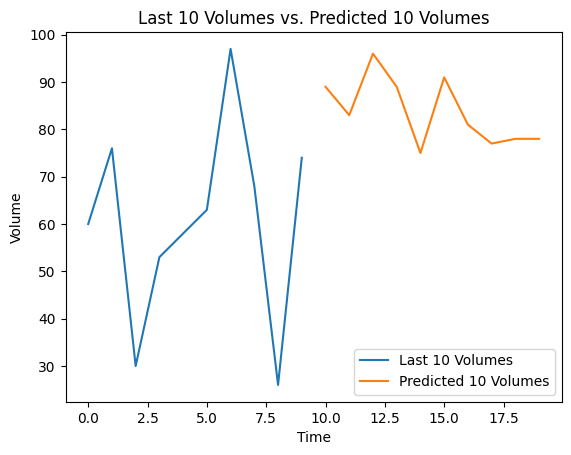

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def predict_next_10_volumes(data):
    """
    Predicts the next 10 volumes using a Markov Chain.

    Args:
        data: List of volume data.

    Returns:
        List of predicted next 10 volumes.
    """

    # Discretize volumes into states (e.g., Low, Medium, High)
    # Example discretization using quantiles:
    low_threshold = np.quantile(data, 0.33)
    high_threshold = np.quantile(data, 0.66)
    states = np.where(data < low_threshold, 'Low', np.where(data > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Predict next 10 volumes
    current_state = states[-1]  # Last observed state
    predicted_volumes = []
    for _ in range(10):
        predicted_next_state = transition_matrix[transition_matrix.index == current_state].idxmax(axis=1).values[0]
        # Map predicted state back to volume range
        if predicted_next_state == 'Low':
            predicted_volume = np.random.randint(int(data.min()), int(low_threshold))
        elif predicted_next_state == 'High':
            predicted_volume = np.random.randint(int(high_threshold), int(data.max()))
        else:  # Medium
            predicted_volume = np.random.randint(int(low_threshold), int(high_threshold))
        predicted_volumes.append(predicted_volume)
        current_state = predicted_next_state

    return predicted_volumes

# Example usage:
data = np.random.randint(10, 101, size=100)  # Replace with your actual data
predicted_volumes = predict_next_10_volumes(data)
print("Predicted next 10 volumes:", predicted_volumes)

# Assuming you have the original data in a variable called 'data'
last_10_volumes = data[-10:]

# Create x-axis values for plotting
x_values_last_10 = np.arange(len(last_10_volumes))
x_values_predicted = np.arange(len(last_10_volumes), len(last_10_volumes) + len(predicted_volumes))

# Plot the last 10 volumes
plt.plot(x_values_last_10, last_10_volumes, label='Last 10 Volumes')

# Plot the predicted 10 volumes
plt.plot(x_values_predicted, predicted_volumes, label='Predicted 10 Volumes')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Last 10 Volumes vs. Predicted 10 Volumes')

# Add legend
plt.legend()

# Display the chart
plt.show()

# Pearson

**Pearson Correlation Coefficient**

In [ ]:
df[['Close', 'Volume']].corr()
df['Close'].corr(df['Volume'])

0.4058513721991079

# Random Forest

Mean Squared Error: 561741621946112.2
R-squared: 0.2639576064805669


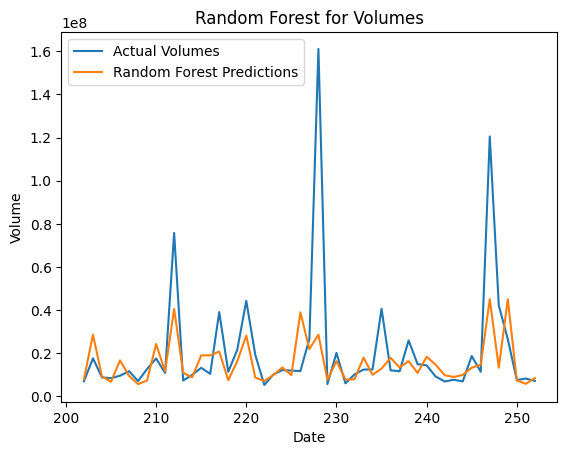

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the volume column is 'Volume'

# Prepare data
X = np.arange(len(df)).reshape(-1, 1)  # Feature matrix (time steps)
y = df['Volume']  # Target variable (volume)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

# Plot the results
plt.plot(df.index[-len(y_test):], y_test, label='Actual Volumes')
plt.plot(df.index[-len(y_test):], predictions, label='Random Forest Predictions')
plt.legend()
plt.title('Random Forest for Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()